In [12]:
from ddpm import DDPM
from utils import load_model
from dataloader import get_dataloader
import torch
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from metrics import preprocess_fid_score
import pickle


This notebook showcases some of the main points of our project. You are also welcome to run

```python train.py MNIST 200 128 0.1 0.002 True```

on a machine with GPU. Requirements are in requirements.txt. 

In [2]:
dataset_name = 'MNIST'
batchsize = 12
dataloader = get_dataloader(dataset_name, batchsize)
ddpm = DDPM()
model_path = f'../DDPM/MNIST_7.pth' #TODO: change this to the path of your model
model, _, _, _ = load_model(dataset_name, 'cpu', 0.1, 0.002, path=model_path)

## Noising

The follwing code implements noising of an image according to a timestamp $t$ and an associated $\beta_t$

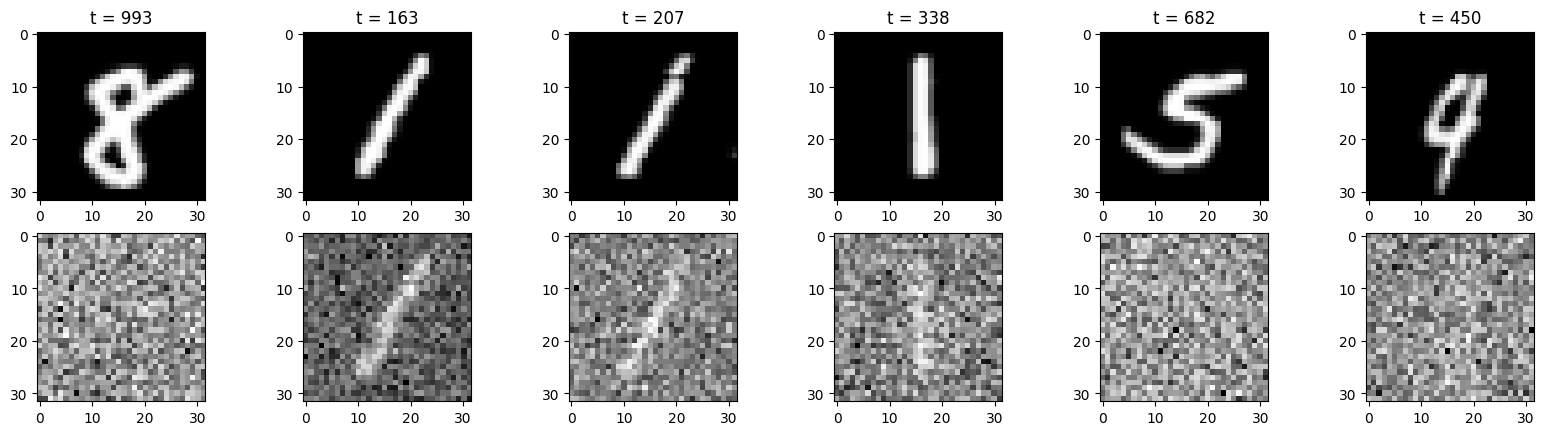

In [3]:
images, _ = next(iter(dataloader))
noise_pred, noise, noised_img, t = ddpm.noising_function(images, batchsize, model)


fig, axs = plt.subplots(2, 6)
fig.set_figwidth(20)
for i in range(batchsize//2):
    axs[0][i].imshow(images[i, 0, :, :].detach().numpy(), cmap='Greys_r')
    axs[1][i].imshow(noised_img[i, 0, :, :].detach().numpy(), cmap='Greys_r')
    axs[0][i].set_title(f't = {t[i].item()}')
plt.show()

# Sampling

We can freely sample from the trained model by generating random noise, and passing it through the model with $t=T=1000$. This might take some time depending on the number of images generated

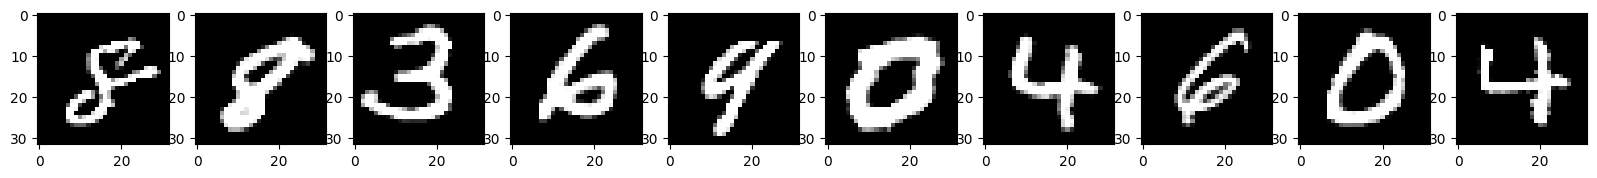

In [4]:
num_img = 10
sampled_images = ddpm.sampling_image(model, num_img = num_img, channels=1,  img_shape=32)

fig, axs = plt.subplots(1, num_img)
fig.set_figwidth(20)
for i in range(num_img):
    axs[i].imshow(sampled_images[i, 0, :, :].detach().numpy(), cmap='Greys_r')
plt.show()

# Evaluation

The performance of a generative model can be evaluated using FID score as well as visual inspection. Below is our FID calculation and feel free to change the fid_dim. As calculating mean and covariance on the entire dataset normally takes a long time, so we opted to provide a pickle with these calculations already done on the real images. Ideally the number of sampled images is larger than fid_dim, so run ```eval.py``` to see the full calculation.



In [16]:
fid_dim = 64 # according to the paper it is 2048

with open(f'fid_{dataset_name}_{fid_dim}.pkl', 'rb') as f:
    fid = pickle.load(f)

# uncomment this section to sample more images
#num_img = fid_dim + 1
#sampled_images = ddpm.sampling_image(model, num_img = num_img, channels=1,  img_shape=32)

fid.update(preprocess_fid_score(sampled_images, 'cpu'), real=False)
fid_score = fid.compute()

print("FID score: ", fid_score)

FID score:  tensor(0.2459)
